In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the Repeat-Vector model

In [3]:
# decoder input: original time series value at last time step

class RepeatVector(object):

    def __init__(self, hidden_num, inputs, optimizer=None, reverse=True,):
        # inputs is a list with length step_num.
        # each element in inputs has size (batch_num,elem_num)
        
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
 

        self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)
        self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num,use_peepholes=True)

        
        
        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)
            
        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            #Repeat vector
            dec_inputs = [self.z_codes[-1] for _ in range(len(self.z_codes))]

            (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)
 
            if reverse:
                dec_outputs = dec_outputs[::-1]

            dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
            dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
            self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_
       

        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))
   
        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_powerdemand_v1.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]
#squeeze: remove [1]dim
#split: split p_input into step_num tensors along dim 1.
# so for t in tf.split(p_input, step_num, 1), t has size (batch_num,1,elem_num)
# and each element in p_inputs has shape(batch_num,elem_num), totally step_num elements


In [8]:
ae = RepeatVector(hidden_num, p_inputs)

(3, 40)


# Training

iter 1: 0.0571398
iter 2: 0.037581
iter 3: 0.045068
iter 4: 0.0419363
iter 5: 0.0397746
iter 6: 0.0403144
iter 7: 0.0395067
iter 8: 0.0464436
iter 9: 0.0481307
iter 10: 0.0409786
iter 11: 0.0380233
iter 12: 0.0315198
iter 13: 0.0376099
iter 14: 0.041612
iter 15: 0.0478229
iter 16: 0.0361568
iter 17: 0.039983
iter 18: 0.0340953
iter 19: 0.0380096
iter 20: 0.0331118
iter 21: 0.0410374
iter 22: 0.0428859
iter 23: 0.0395086
iter 24: 0.0382631
iter 25: 0.0395665
iter 26: 0.0338237
iter 27: 0.0410201
iter 28: 0.0402858
iter 29: 0.0383534
iter 30: 0.0299503
iter 31: 0.0287235
iter 32: 0.035291
iter 33: 0.035664
iter 34: 0.0386425
iter 35: 0.0298441
iter 36: 0.0334506
iter 37: 0.0341278
iter 38: 0.0429782
iter 39: 0.0323591
iter 40: 0.0438233
iter 41: 0.0353206
iter 42: 0.0346413
iter 43: 0.0381157
iter 44: 0.0442862
iter 45: 0.0335479
iter 46: 0.037377
iter 47: 0.0346031
iter 48: 0.0291068
iter 49: 0.0325897
iter 50: 0.0301228
iter 51: 0.0362191
iter 52: 0.034256
iter 53: 0.0379556
iter 54: 0

iter 420: 0.0280952
iter 421: 0.0294154
iter 422: 0.0276973
iter 423: 0.0324488
iter 424: 0.0310807
iter 425: 0.0376529
iter 426: 0.0280426
iter 427: 0.0274575
iter 428: 0.0328433
iter 429: 0.0250436
iter 430: 0.0258369
iter 431: 0.0201762
iter 432: 0.0575423
iter 433: 0.0372446
iter 434: 0.0407566
iter 435: 0.0341941
iter 436: 0.0369239
iter 437: 0.0405618
iter 438: 0.0336797
iter 439: 0.0314007
iter 440: 0.0373852
iter 441: 0.0366871
iter 442: 0.0378223
iter 443: 0.0326195
iter 444: 0.0322996
iter 445: 0.0360183
iter 446: 0.0332338
iter 447: 0.0337116
iter 448: 0.0339054
iter 449: 0.0389116
iter 450: 0.0283644
iter 451: 0.0299673
iter 452: 0.0363456
iter 453: 0.029941
iter 454: 0.0373049
iter 455: 0.0351334
iter 456: 0.0319942
iter 457: 0.0418631
iter 458: 0.0345796
iter 459: 0.0347517
iter 460: 0.0321073
iter 461: 0.0366574
iter 462: 0.0285764
iter 463: 0.042691
iter 464: 0.0289313
iter 465: 0.0392835
iter 466: 0.038668
iter 467: 0.0309756
iter 468: 0.0292364
iter 469: 0.0336804
ite

iter 836: 0.0369674
iter 837: 0.0310965
iter 838: 0.0293625
iter 839: 0.032765
iter 840: 0.0340878
iter 841: 0.032896
iter 842: 0.033384
iter 843: 0.0331001
iter 844: 0.0328743
iter 845: 0.0311657
iter 846: 0.0366191
iter 847: 0.0305663
iter 848: 0.0330818
iter 849: 0.0318046
iter 850: 0.0259825
iter 851: 0.0350202
iter 852: 0.0323698
iter 853: 0.0303574
iter 854: 0.0309718
iter 855: 0.0313972
iter 856: 0.0318408
iter 857: 0.0344048
iter 858: 0.0326001
iter 859: 0.0299546
iter 860: 0.0290294
iter 861: 0.032425
iter 862: 0.0350818
iter 863: 0.0370384
iter 864: 0.0382684
iter 865: 0.0316594
iter 866: 0.0313672
iter 867: 0.0277622
iter 868: 0.0333867
iter 869: 0.0274097
iter 870: 0.0367596
iter 871: 0.029215
iter 872: 0.0258705
iter 873: 0.0365957
iter 874: 0.0280621
iter 875: 0.0321829
iter 876: 0.0301431
iter 877: 0.0329469
iter 878: 0.0378309
iter 879: 0.03389
iter 880: 0.027881
iter 881: 0.0364054
iter 882: 0.0377355
iter 883: 0.0351732
iter 884: 0.030592
iter 885: 0.033493
iter 886: 

iter 1227: 0.00529327
iter 1228: 0.00437962
iter 1229: 0.00592766
iter 1230: 0.00407542
iter 1231: 0.00427676
iter 1232: 0.00492008
iter 1233: 0.00409334
iter 1234: 0.00433033
iter 1235: 0.00337083
iter 1236: 0.00520623
iter 1237: 0.00455185
iter 1238: 0.00444333
iter 1239: 0.00441046
iter 1240: 0.00398128
iter 1241: 0.00503638
iter 1242: 0.00576934
iter 1243: 0.00435232
iter 1244: 0.00370509
iter 1245: 0.00455688
iter 1246: 0.00449541
iter 1247: 0.00656433
iter 1248: 0.00693013
iter 1249: 0.00458935
iter 1250: 0.00619488
iter 1251: 0.00541697
iter 1252: 0.00487589
iter 1253: 0.00375191
iter 1254: 0.00557684
iter 1255: 0.00466727
iter 1256: 0.00447982
iter 1257: 0.00446529
iter 1258: 0.00423837
iter 1259: 0.0042373
iter 1260: 0.00668991
iter 1261: 0.00405848
iter 1262: 0.00347457
iter 1263: 0.00474628
iter 1264: 0.00450673
iter 1265: 0.00455386
iter 1266: 0.00442477
iter 1267: 0.00474123
iter 1268: 0.00335031
iter 1269: 0.00460251
iter 1270: 0.00411422
iter 1271: 0.00347126
iter 1272: 

iter 1602: 0.00390412
iter 1603: 0.00386722
iter 1604: 0.00457264
iter 1605: 0.00433795
iter 1606: 0.00370083
iter 1607: 0.00551917
iter 1608: 0.00464332
iter 1609: 0.00506428
iter 1610: 0.0038259
iter 1611: 0.00388274
iter 1612: 0.0033087
iter 1613: 0.00283217
iter 1614: 0.00308744
iter 1615: 0.00438817
iter 1616: 0.00418045
iter 1617: 0.00278016
iter 1618: 0.00395321
iter 1619: 0.00351664
iter 1620: 0.00369951
iter 1621: 0.00309544
iter 1622: 0.00269956
iter 1623: 0.00362718
iter 1624: 0.00469298
iter 1625: 0.00352741
iter 1626: 0.00364193
iter 1627: 0.00399575
iter 1628: 0.00354756
iter 1629: 0.00274123
iter 1630: 0.00303658
iter 1631: 0.00543435
iter 1632: 0.00311794
iter 1633: 0.00412742
iter 1634: 0.00487779
iter 1635: 0.00406789
iter 1636: 0.00325856
iter 1637: 0.00393615
iter 1638: 0.00408166
iter 1639: 0.00382264
iter 1640: 0.00378253
iter 1641: 0.00473887
iter 1642: 0.00400584
iter 1643: 0.00506303
iter 1644: 0.00309013
iter 1645: 0.00370131
iter 1646: 0.00268785
iter 1647: 0

iter 1978: 0.00429347
iter 1979: 0.006875
iter 1980: 0.00394525
iter 1981: 0.00831076
iter 1982: 0.00457828
iter 1983: 0.00729525
iter 1984: 0.00380306
iter 1985: 0.00596276
iter 1986: 0.00457548
iter 1987: 0.00605212
iter 1988: 0.00401458
iter 1989: 0.0053181
iter 1990: 0.00466061
iter 1991: 0.00413739
iter 1992: 0.0039609
iter 1993: 0.00682965
iter 1994: 0.0035004
iter 1995: 0.00444292
iter 1996: 0.00374588
iter 1997: 0.00581636
iter 1998: 0.00504609
iter 1999: 0.00436591
iter 2000: 0.00450682
iter 2001: 0.00288374
iter 2002: 0.00462963
iter 2003: 0.00500736
iter 2004: 0.00386822
iter 2005: 0.00488967
iter 2006: 0.00481273
iter 2007: 0.00388372
iter 2008: 0.00373542
iter 2009: 0.00327273
iter 2010: 0.00459718
iter 2011: 0.00335133
iter 2012: 0.00313739
iter 2013: 0.00331436
iter 2014: 0.00320177
iter 2015: 0.00288531
iter 2016: 0.00316644
iter 2017: 0.00277884
iter 2018: 0.00610016
iter 2019: 0.00375662
iter 2020: 0.00423163
iter 2021: 0.00375978
iter 2022: 0.00412429
iter 2023: 0.00

iter 2353: 0.00357063
iter 2354: 0.00267746
iter 2355: 0.00268047
iter 2356: 0.00261658
iter 2357: 0.00313733
iter 2358: 0.00441336
iter 2359: 0.00318922
iter 2360: 0.00277949
iter 2361: 0.00384421
iter 2362: 0.00222471
iter 2363: 0.00422152
iter 2364: 0.00374543
iter 2365: 0.00187771
iter 2366: 0.00436597
iter 2367: 0.00346871
iter 2368: 0.00272214
iter 2369: 0.0029209
iter 2370: 0.00371011
iter 2371: 0.00344308
iter 2372: 0.00402881
iter 2373: 0.00330007
iter 2374: 0.00327405
iter 2375: 0.00218155
iter 2376: 0.00419144
iter 2377: 0.00290633
iter 2378: 0.00222268
iter 2379: 0.00382022
iter 2380: 0.00376856
iter 2381: 0.00415944
iter 2382: 0.00363981
iter 2383: 0.00383874
iter 2384: 0.00343314
iter 2385: 0.00271548
iter 2386: 0.00346859
iter 2387: 0.00266129
iter 2388: 0.00339269
iter 2389: 0.0024673
iter 2390: 0.00336214
iter 2391: 0.00455373
iter 2392: 0.00355984
iter 2393: 0.00353359
iter 2394: 0.00257044
iter 2395: 0.00353142
iter 2396: 0.002838
iter 2397: 0.00362412
iter 2398: 0.0

iter 2729: 0.00364034
iter 2730: 0.00339627
iter 2731: 0.00493607
iter 2732: 0.00329303
iter 2733: 0.00269779
iter 2734: 0.0034173
iter 2735: 0.00355102
iter 2736: 0.00335025
iter 2737: 0.00264297
iter 2738: 0.00361327
iter 2739: 0.00344004
iter 2740: 0.00336787
iter 2741: 0.00320324
iter 2742: 0.00238317
iter 2743: 0.0028206
iter 2744: 0.00245603
iter 2745: 0.00268045
iter 2746: 0.0017888
iter 2747: 0.00239922
iter 2748: 0.00292413
iter 2749: 0.00325232
iter 2750: 0.00376498
iter 2751: 0.0024924
iter 2752: 0.0042516
iter 2753: 0.00230314
iter 2754: 0.00284199
iter 2755: 0.0035587
iter 2756: 0.00382301
iter 2757: 0.00387497
iter 2758: 0.00360208
iter 2759: 0.0027207
iter 2760: 0.00340338
iter 2761: 0.00251621
iter 2762: 0.00289056
iter 2763: 0.0032201
iter 2764: 0.0031455
iter 2765: 0.00308384
iter 2766: 0.00371642
iter 2767: 0.0029766
iter 2768: 0.0031685
iter 2769: 0.003311
iter 2770: 0.0029553
iter 2771: 0.00373288
iter 2772: 0.00414402
iter 2773: 0.00256216
iter 2774: 0.0044592
ite

iter 3105: 0.00257776
iter 3106: 0.00194592
iter 3107: 0.00167399
iter 3108: 0.00276517
iter 3109: 0.00219616
iter 3110: 0.00258445
iter 3111: 0.00250177
iter 3112: 0.00230351
iter 3113: 0.00254696
iter 3114: 0.00216247
iter 3115: 0.00222227
iter 3116: 0.00240228
iter 3117: 0.00284916
iter 3118: 0.00238889
iter 3119: 0.00295784
iter 3120: 0.00262485
iter 3121: 0.00187184
iter 3122: 0.0025465
iter 3123: 0.00246752
iter 3124: 0.00309366
iter 3125: 0.0016211
iter 3126: 0.00257761
iter 3127: 0.00232174
iter 3128: 0.00265251
iter 3129: 0.00333558
iter 3130: 0.00321212
iter 3131: 0.00219473
iter 3132: 0.00427152
iter 3133: 0.0023236
iter 3134: 0.00371278
iter 3135: 0.00195945
iter 3136: 0.00305406
iter 3137: 0.00251526
iter 3138: 0.00247569
iter 3139: 0.00331663
iter 3140: 0.00257537
iter 3141: 0.00260555
iter 3142: 0.00176571
iter 3143: 0.00430899
iter 3144: 0.00260799
iter 3145: 0.00274714
iter 3146: 0.00185781
iter 3147: 0.00300183
iter 3148: 0.00235676
iter 3149: 0.00257133
iter 3150: 0.

iter 3482: 0.0029432
iter 3483: 0.00181823
iter 3484: 0.00203129
iter 3485: 0.00174407
iter 3486: 0.00186651
iter 3487: 0.00235521
iter 3488: 0.0018092
iter 3489: 0.00257363
iter 3490: 0.002174
iter 3491: 0.00189606
iter 3492: 0.00255391
iter 3493: 0.00152533
iter 3494: 0.00199146
iter 3495: 0.0021846
iter 3496: 0.00168439
iter 3497: 0.00150555
iter 3498: 0.00125768
iter 3499: 0.00164298
iter 3500: 0.00156872
iter 3501: 0.00135429
iter 3502: 0.00160988
iter 3503: 0.00184436
iter 3504: 0.00167705
iter 3505: 0.00221097
iter 3506: 0.00202581
iter 3507: 0.00216035
iter 3508: 0.00213123
iter 3509: 0.00137571
iter 3510: 0.0024759
iter 3511: 0.0016075
iter 3512: 0.00183734
iter 3513: 0.00162853
iter 3514: 0.00231157
iter 3515: 0.00165627
iter 3516: 0.00216404
iter 3517: 0.00208795
iter 3518: 0.0015857
iter 3519: 0.00230287
iter 3520: 0.00199819
iter 3521: 0.00165289
iter 3522: 0.00259533
iter 3523: 0.00264507
iter 3524: 0.0022663
iter 3525: 0.00331417
iter 3526: 0.00186305
iter 3527: 0.002340

iter 3857: 0.00187566
iter 3858: 0.00420131
iter 3859: 0.00327657
iter 3860: 0.00280639
iter 3861: 0.00231821
iter 3862: 0.004236
iter 3863: 0.00232143
iter 3864: 0.00400955
iter 3865: 0.00225243
iter 3866: 0.00384474
iter 3867: 0.00209134
iter 3868: 0.00449433
iter 3869: 0.00209765
iter 3870: 0.00421206
iter 3871: 0.00360536
iter 3872: 0.00292159
iter 3873: 0.00495114
iter 3874: 0.00237919
iter 3875: 0.00580108
iter 3876: 0.0019049
iter 3877: 0.00562965
iter 3878: 0.00220417
iter 3879: 0.00360281
iter 3880: 0.00166678
iter 3881: 0.00360783
iter 3882: 0.00231395
iter 3883: 0.00203637
iter 3884: 0.00311891
iter 3885: 0.00241596
iter 3886: 0.00252352
iter 3887: 0.00178402
iter 3888: 0.00305722
iter 3889: 0.00193857
iter 3890: 0.00244118
iter 3891: 0.00170406
iter 3892: 0.00327931
iter 3893: 0.00172907
iter 3894: 0.00213233
iter 3895: 0.00203582
iter 3896: 0.00440986
iter 3897: 0.00173877
iter 3898: 0.00301197
iter 3899: 0.00239912
iter 3900: 0.00265816
iter 3901: 0.00103558
iter 3902: 0.

iter 4233: 0.00184261
iter 4234: 0.00171889
iter 4235: 0.0013946
iter 4236: 0.00181456
iter 4237: 0.00198219
iter 4238: 0.00202982
iter 4239: 0.00296609
iter 4240: 0.00277053
iter 4241: 0.00136779
iter 4242: 0.00277724
iter 4243: 0.00172979
iter 4244: 0.00333803
iter 4245: 0.00358581
iter 4246: 0.00456398
iter 4247: 0.00327325
iter 4248: 0.0033654
iter 4249: 0.00226909
iter 4250: 0.0013425
iter 4251: 0.00274073
iter 4252: 0.00234954
iter 4253: 0.00253882
iter 4254: 0.00245736
iter 4255: 0.00340016
iter 4256: 0.00165102
iter 4257: 0.00267106
iter 4258: 0.00186188
iter 4259: 0.00216506
iter 4260: 0.00172554
iter 4261: 0.00157189
iter 4262: 0.00264052
iter 4263: 0.00166203
iter 4264: 0.00287387
iter 4265: 0.00118406
iter 4266: 0.00165692
iter 4267: 0.00195277
iter 4268: 0.00142131
iter 4269: 0.00185284
iter 4270: 0.00144071
iter 4271: 0.00176112
iter 4272: 0.00137427
iter 4273: 0.00118345
iter 4274: 0.00163498
iter 4275: 0.001858
iter 4276: 0.0016307
iter 4277: 0.00197589
iter 4278: 0.001

iter 4607: 0.00138078
iter 4608: 0.00191983
iter 4609: 0.0020159
iter 4610: 0.00148615
iter 4611: 0.001685
iter 4612: 0.000834116
iter 4613: 0.00123907
iter 4614: 0.00219302
iter 4615: 0.00109809
iter 4616: 0.00170633
iter 4617: 0.00094741
iter 4618: 0.00133783
iter 4619: 0.00119193
iter 4620: 0.00160749
iter 4621: 0.00138693
iter 4622: 0.0010084
iter 4623: 0.00110056
iter 4624: 0.00198508
iter 4625: 0.00184146
iter 4626: 0.0015258
iter 4627: 0.00119676
iter 4628: 0.00134385
iter 4629: 0.00109174
iter 4630: 0.00111202
iter 4631: 0.00107045
iter 4632: 0.00158753
iter 4633: 0.00094982
iter 4634: 0.00144561
iter 4635: 0.00116685
iter 4636: 0.00150297
iter 4637: 0.00297913
iter 4638: 0.00136376
iter 4639: 0.00168617
iter 4640: 0.000931734
iter 4641: 0.00169036
iter 4642: 0.000895387
iter 4643: 0.00140288
iter 4644: 0.00142052
iter 4645: 0.00207011
iter 4646: 0.00101438
iter 4647: 0.00117067
iter 4648: 0.00186177
iter 4649: 0.00128237
iter 4650: 0.000911896
iter 4651: 0.00133081
iter 4652: 

iter 4982: 0.00263903
iter 4983: 0.00160764
iter 4984: 0.0018211
iter 4985: 0.00100901
iter 4986: 0.00158909
iter 4987: 0.00166107
iter 4988: 0.00178085
iter 4989: 0.00155578
iter 4990: 0.00138036
iter 4991: 0.00228863
iter 4992: 0.0017506
iter 4993: 0.0017484
iter 4994: 0.0021191
iter 4995: 0.00193498
iter 4996: 0.00137248
iter 4997: 0.00201088
iter 4998: 0.00168564
iter 4999: 0.00177134
iter 5000: 0.000861613
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_v1.ckpt


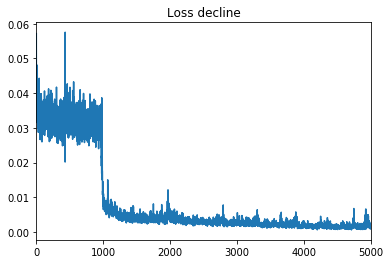

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_v1.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]
threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

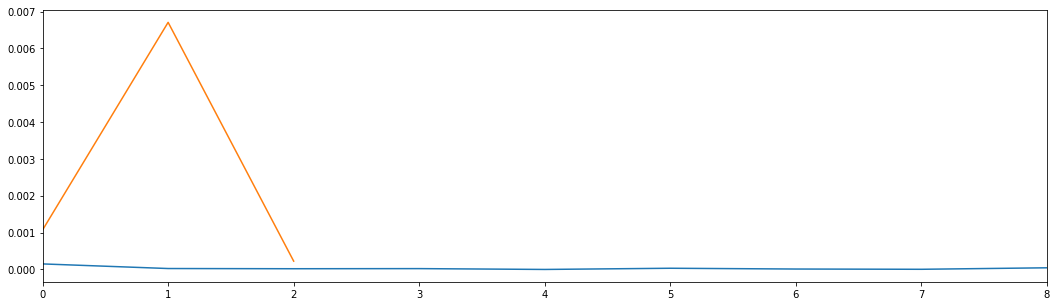

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/repeatvector_v1.ckpt
Model restored.
Initialized


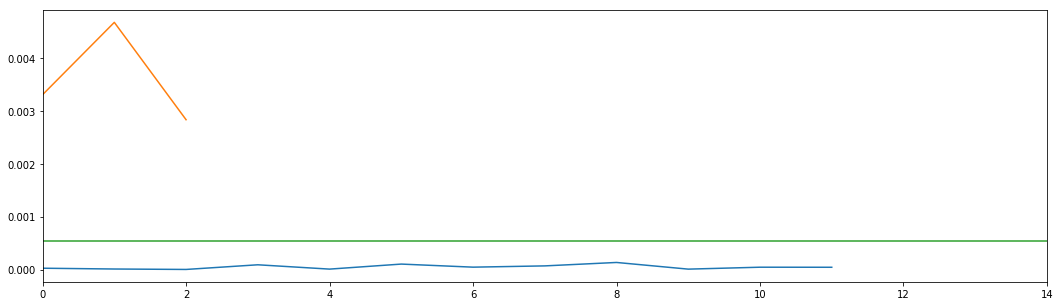

In [14]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

            
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [15]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

1.0

In [16]:
print(tp,fp,tn,fn,P,R)

3 0 12 0 1.0 1.0
